### Inventory Model

#### 1. Load the Required Libraries


In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.layers import StringLookup, IntegerLookup, Normalization, CategoryEncoding
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow_datasets as tfds

import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

2024-03-25 18:33:05.441302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 18:33:05.483538: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 18:33:05.484211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 18:33:06.326831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/babi/miniconda3/envs/week10/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv("../data/model_data.csv")

In [3]:
dataset.iloc[:1, :].to_dict(orient="records")[0]

{'geo_targeting': 'Unknown',
 'vertical': 'Sports',
 'adformat': '320x480',
 'creative': 'Sensory Video',
 'renderingcontext': 'MobileOptimizedWeb',
 'osfamily': 'Android',
 'devicetype': 'Tablet',
 'devicemake': 'Samsung',
 'matchedfoldposition': 'Unknown',
 'browser': 'Chrome',
 'CTR': 0.0}

In [4]:
dataset.dtypes

geo_targeting           object
vertical                object
adformat                object
creative                object
renderingcontext        object
osfamily                object
devicetype              object
devicemake              object
matchedfoldposition     object
browser                 object
CTR                    float64
dtype: object

#### 2: Encode Categorical Columns

In [5]:
# Simulating tfds.features.ClassLabel behavior with LabelEncoder for the specified columns
label_encoders = {}
for column in ['matchedfoldposition', 'devicetype', 'osfamily']:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    label_encoders[column] = le 

#### 5: Convert to TensorFlow Dataset

In [31]:
sample_dataset = dataset.iloc[:1000, :]
sample_dataset.shape

(1000, 11)

In [32]:
features_with_ctr = {name: np.array(value) for name, value in sample_dataset.items()}
dataset_tf = tf.data.Dataset.from_tensor_slices(features_with_ctr)

# Batch the dataset
# dataset_tf = dataset_tf.batch(32)

In [33]:
tf.random.set_seed(42)
length = len(dataset_tf)
train_size = int(length * 0.8)
test_size = length - train_size
shuffled = dataset_tf.shuffle(length, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

##### Then, we create vocabulary for each feature.

In [34]:
feature_names = ["geo_targeting", "vertical", "adformat", "creative",
                 "renderingcontext", "osfamily", "devicetype", "devicemake", 
                 "matchedfoldposition", "browser"]

vocabularies = {}

for feature_name in feature_names:
  vocab = dataset_tf.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [35]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["geo_targeting", "vertical", "adformat", "creative",
                 "renderingcontext", "devicemake", "browser"]
    int_features = ["matchedfoldposition", "osfamily"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("CTR")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

### Model training
We shuffle, batch and cache the training and test data. 

In [36]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs.

In [37]:
epochs = 8
learning_rate = 0.01

In [38]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

**DCN (stacked).** We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1X8qoMtIYKJz4yBYifvfw4QpAwrjr70e_" width="140"/>
</center>
</div>


In [44]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

1/1 [==============================] - 0s 115ms/step - RMSE: 5.2750 - loss: 27.8255 - regularization_loss: 0.0000e+00 - total_loss: 27.8255


**Low-rank DCN.** To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument `projection_dim`; a smaller `projection_dim` results in a lower cost. Note that `projection_dim` needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1ZZfUTNdxjGAaAuwNrweKkLJ1PGxMmiCm" width="400"/>
</center>
</div>


In [45]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

1/1 [==============================] - 0s 129ms/step - RMSE: 5.5927 - loss: 31.2786 - regularization_loss: 0.0000e+00 - total_loss: 31.2786


**DNN.** We train a same-sized DNN model as a reference.

In [46]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

1/1 [==============================] - 0s 108ms/step - RMSE: 5.0183 - loss: 25.1830 - regularization_loss: 0.0000e+00 - total_loss: 25.1830


We evaluate the model on test data and report the mean and standard deviation out of 5 runs.

In [47]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))


DCN            RMSE mean: 5.3667, stdv: 0.2819
DCN (low-rank) RMSE mean: 5.3974, stdv: 0.2303
DNN            RMSE mean: 5.0569, stdv: 0.0389


### Model understanding

The weight matrix $W$ in DCN reveals what feature crosses the model has learned to be important. Recall that in the previous toy example, the importance of interactions between the $i$-th and $j$-th features is captured by the ($i, j$)-th element of $W$.

What's a bit different here is that the feature embeddings are of size 32 instead of size 1. Hence, the importance will be characterized by the $(i, j)$-th block
$W_{i,j}$ which is of dimension 32 by 32.
In the following, we visualize the Frobenius norm [[4](https://en.wikipedia.org/wiki/Matrix_norm)] $||W_{i,j}||_F$ of each block, and a larger norm would suggest higher importance (assuming the features' embeddings are of similar scales).

Besides block norm, we could also visualize the entire matrix, or the mean/median/max value of each block.

/tmp/ipykernel_192615/1244897914.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/tmp/ipykernel_192615/1244897914.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

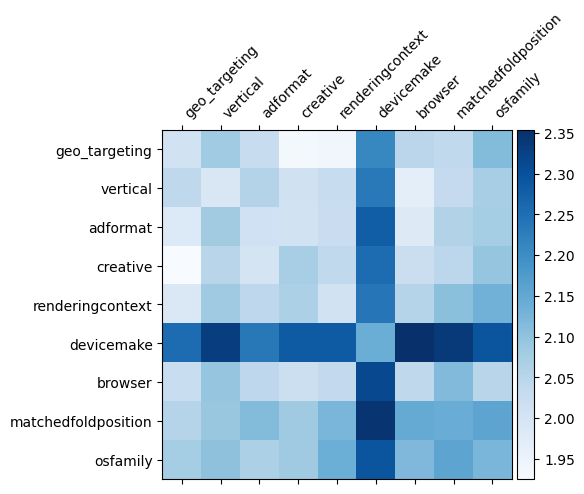

In [48]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)